# Introduction

This notebook is an exploration of the NHL player 2004-2018 dataset shared on Kaggle.com (generated from hockey-reference.com). The primary goal of this project is to discover whether we can group hockey teams in a meaningful way. People naturally try to classify teams into groups. For example, a plausible distinction to make is between teams that are more offensively focused from other teams that are more defensively focused. The use of such distinctions is straight-forward, with them we can formulate questions such as whether offensively focused or definsively focused teams more successful at winning championships. Answers to questions like these have potential import for decision making. This [article](https://www.thestar.com/sports/hockey/2014/05/29/in_the_nhl_defence_doesnt_actually_win_championships_hockey_analytics.html) argues that offensively focused teams are typically more successful when it comes to winning championships in hockey. They rely on goals for and goals against for a team to make their case (teams with high goals for being offensively focused and teams with few goals against being defensively focused). 

By doing a cluster analysis on multiple features I will investigate whether we can make a distinction between types of teams where If successful this should be an improvement on intuitive distinctions (and/or distinctions made precise using just a few features). To measure the degree of success I will get some data about which teams make the playoffs and which teams win the championship to see if the groups correlate with success and failure. This notebook represents the first iteration of this project and so is mainly a proof of concept. I will consider ways to move forward with the project if the basic framework is successful. 

There are three main steps that will be taken in this project. Since the chosen dataset is at the player level (each observation is for a player in a season), the data will first need to be rolled up to the team/season level. Then I will use k-means cluster analysis to group the team and season pairs. Finally, I will consider what if anything can be learned from the cluster analysis.

## Outline
 1. Import packages and data
 2. Address any null values and other issues with the data
 3. Determine which columns to aggregate and which functions to apply to them
 4. Roll up to team level data
 5. Verify everything looks right and fix any problems
 6. Perform K-means clustering
 7. Get playoff data by scraping it from hockey-reference.com
 8. Check correlations to evaluate whether clusters are informative



In [272]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import data
player_data = pd.read_csv('nhl_datasets/NHL_2004_to_2018_Player_Data.csv', encoding='latin-1')

In [273]:
#First Look
player_data.head()

,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
0,1,Connor McDavid\mcdavco01,20,C,EDM,82,30,70,100,27,...,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby\crosbsi01,29,C,PIT,75,44,45,89,17,...,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane\kanepa01,28,RW,CHI,82,34,55,89,11,...,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom\backsni02,29,C,WSH,82,23,63,86,17,...,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov\kucheni01,23,RW,TBL,74,40,45,85,13,...,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017


In [274]:
#Check for Nulls
player_data.isnull().sum()

Rk              0
Player          0
Age             0
Pos             0
Tm              0
GP              0
G               0
A               0
PTS             0
plusminus       0
PIM             0
PS              0
EV              0
PP              0
SH              0
GW              0
EV.1            0
PP.1            0
SH.1            0
S               0
S_percent     124
TOI             0
ATOI            0
BLK             1
HIT             0
FOW             1
FOL             1
FO_percent    311
HART            0
Votes           0
Season          0
dtype: int64

We have some null values to look into. I will start by checking the single null value in BLK.

In [275]:
player_data[player_data.BLK.isnull()]

,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
13149,854,Brian Lashoff\lashobr01,27,D,DET,1,0,0,0,0,...,4,4.0,NaN,0,NaN,NaN,NaN,0,0,2018


It appears that one player is responsible for the single null value in three columns. Given that he only played for four minutes in one game I will drop him.

In [276]:
player_data.drop([13149], inplace=True)
player_data[['BLK','FOW','FOL']].isnull().sum()

BLK    0
FOW    0
FOL    0
dtype: int64

Now let's deal with the null values in 'S_percent'.

In [277]:
player_data[player_data.S_percent.isnull()].S.unique()

array([0], dtype=int64)

It appears that the null values in shot percentage column results from players that have zero shots. I'll replace these null values with a zero. But it really doesn't matter because we can just calculate team shooting percentage once I roll up total goals and total shots to the team level.

In [278]:
player_data.S_percent.fillna(0, inplace=True)
player_data.S_percent.isnull().sum()

0

Now lets deal with the null values in 'FO_percent'.

In [279]:
display(player_data[player_data.FO_percent.isnull()].FOL.unique())
display(player_data[player_data.FO_percent.isnull()].FOW.unique())

array([0.])

array([0.])

Similarly it appears these values are null for players who have zero faceoff wins or losses. I'll replace the null values with zeros. But it won't matter anyway for similar reasons to shooting percentage.

In [280]:
player_data.FO_percent.fillna(0, inplace=True)
player_data.FO_percent.isnull().sum()

0

Before we get to rolling up the data to the team level, there is a problem with the 2009 season player data. This problem didn't reveal itself until I did the cluster analysis and found the 2009 team data to be off. We can see the problem here though.

In [281]:
player_data[(player_data.Season == 2009) & (player_data.Player =='Evgeni Malkin\malkiev01')]

,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
7057,1,Evgeni Malkin\malkiev01,22,C,PIT,82,35,78,113,17,...,1846,22.516667,39.0,80,283.0,385.0,42.4,0,787,2009
8811,18,Evgeni Malkin\malkiev01,20,LW,PIT,78,33,52,85,2,...,1494,19.166667,0.0,0,0.0,0.0,0.0,0,0,2009


There are two rows for many players in the 2009 season. They do not have the stats so they are not simply duplicate rows. If we look at the age of the player it appears we should check 2007 and 2011. After checking we can see that the second row is identical to the 2007 row for this player (besides the season).

In [282]:
player_data[(player_data.Season == 2007) & (player_data.Player =='Evgeni Malkin\malkiev01')]

,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
9669,18,Evgeni Malkin\malkiev01,20,LW,PIT,78,33,52,85,2,...,1494,19.166667,0.0,0,0.0,0.0,0.0,0,0,2007


Let's get rid of the duplicate 2007 data mismarked as 2009.

In [283]:
#Plan to use 2007 data and check 2009 data to see if name and age is the same, if so drop it
names_ages_to_drop = player_data[player_data.Season == 2007][['Player', 'Age']].values
values_to_check = player_data[player_data.Season == 2009][['Player', 'Age']].values
index_to_drop = []
for i in names_ages_to_drop:
    if i in values_to_check:
        j = player_data[(player_data.Season == 2009) & (player_data.Player == i[0]) & (player_data.Age == i[1])].index.values[0]
        index_to_drop.append(j)
player_data.drop(index_to_drop, inplace=True)

Let's see if it worked.

In [284]:
player_data[(player_data.Season == 2009) & (player_data.Player =='Evgeni Malkin\malkiev01')]

,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
7057,1,Evgeni Malkin\malkiev01,22,C,PIT,82,35,78,113,17,...,1846,22.516667,39.0,80,283.0,385.0,42.4,0,787,2009


# Roll Up
Now we will plan out the roll up. We will be aggregating columns and so we need to plan out which columns will be aggregated by sum, which by average, etc. We have the following columns to consider.

In [285]:
player_data.columns

Index(['Rk', 'Player', 'Age', 'Pos', 'Tm', 'GP', 'G', 'A', 'PTS', 'plusminus',
       'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S',
       'S_percent', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO_percent',
       'HART', 'Votes', 'Season'],
      dtype='object')

Some of the columns don't need to be included or cannot be included. For example, 'Rk' is essentially just an index. Also, 'Pos' gives the players position and so is not something that would make sense at the team level. The only column we will need to aggregate by counting is 'Player'. So really we just need to determine which columns to sum and which columns to average. Since we will have the player count, we could always determine the sum from the average and vice versa, so really it comes down to interpretability. Where the sum would be hard to make sense of, e.g. Age, I will use the average. 

In [286]:
to_count = ['Player']
to_sum = ['G', 'A', 'S', 'PP', 'SH', 'BLK', 'HIT', 'FOW', 'FOL']
to_avg = ['Age', 'GP', 'PIM', 'PS', 'ATOI']

team_data_dict = {}
for i in to_count:
    team_data_dict[i] = player_data.groupby(['Tm', 'Season'])['{}'.format(i)].count()
for i in to_sum:
    team_data_dict[i] = player_data.groupby(['Tm', 'Season'])['{}'.format(i)].sum()
for i in to_avg:
    team_data_dict[i] = player_data.groupby(['Tm', 'Season'])['{}'.format(i)].mean()
    
team_data = pd.DataFrame(index = team_data_dict['Player'].index)
for i in team_data_dict:
    team_data = team_data.join(team_data_dict[i])

team_data.reset_index(inplace=True)

Let's check the data to see if anything seems problematic.

In [287]:
team_data.Tm.unique()

array(['ANA', 'ARI', 'ATL', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI',
       'COL', 'DAL', 'DET', 'EDM', 'FLA', 'LAK', 'MDA', 'MIN', 'MTL',
       'NJD', 'NSH', 'NYI', 'NYR', 'OTT', 'PHI', 'PHX', 'PIT', 'SJS',
       'STL', 'TBL', 'TOR', 'TOT', 'VAN', 'VEG', 'WPG', 'WSH'],
      dtype=object)

We can already find a few issues here. First, we have 'ATL' and 'WPG' which are in some sense the same team as the Atlanta Falcons moved and became the Winnepeg Jets in 2011. So while this shouldn't be a problem for the analysis, I will just rename 'ATL' as 'WPG' to make things simpler. 

'MDA' and 'ANA' are different names for the same team (MDA stands for Mighty Ducks of Anaheim). So MDA needs to be renamed. 

Similarly, 'PHX' and 'ARI' are different names for the same team (the Phoenix Coyotes became the Arizona Coyotes). So PHY needs to be renamed.

Lastly, 'TOT' does not correspond to any team. Looking into the player level data. It appears that when a player plays for two different teams in a season, there is a row for the player's stats for each team and then a row for the combined stats, which is designated 'TOT'. So we should drop this data as it is already accounted for.

In [288]:
team_data.replace('MDA', 'ANA', inplace=True)
team_data.replace('PHX', 'ARI', inplace=True)
team_data.replace('ATL', 'WPG', inplace=True)
team_data = team_data[team_data.Tm != 'TOT']
team_data.sort_values(by=['Tm', 'Season'], inplace=True)
team_data.reset_index(drop=True, inplace=True)

Let's see what other issues we can find.

In [289]:
team_data.describe()

,Season,Player,G,A,S,PP,SH,BLK,HIT,FOW,FOL,Age,GP,plusminus,PIM,PS,ATOI
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,2011.444181,26.833729,202.361045,344.624703,2177.760095,50.465558,6.591449,788.619952,1259.486936,1700.368171,1701.546318,26.533072,48.660637,0.075066,31.670388,2.553030,14.261391
std,4.165030,2.862051,40.545481,69.820053,355.057939,15.986955,3.502288,442.858585,723.057508,948.258720,941.815830,1.072353,7.661899,4.998548,8.913631,0.734948,0.984450
min,2004.000000,18.000000,88.000000,149.000000,977.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,25.900000,-16.166667,14.000000,0.658065,9.707971
25%,2008.000000,25.000000,182.000000,306.000000,2030.000000,40.000000,4.000000,643.000000,1037.000000,1350.000000,1366.000000,25.851852,44.500000,-3.434783,25.000000,2.012000,13.671667
50%,2012.000000,27.000000,205.000000,352.000000,2247.000000,48.000000,6.000000,968.000000,1485.000000,2177.000000,2167.000000,26.520000,49.678571,0.080000,31.086957,2.610000,14.305357
75%,2015.000000,29.000000,230.000000,392.000000,2409.000000,59.000000,8.000000,1092.000000,1722.000000,2380.000000,2368.000000,27.153846,53.708333,3.230769,38.424242,3.104348,14.973188
max,2018.000000,35.000000,306.000000,521.000000,2965.000000,105.000000,25.000000,1490.000000,2673.000000,2800.000000,2684.000000,30.230769,67.736842,14.200000,56.240000,4.396000,16.279545


It appears the something has gone wrong. The minimum value for blocks, hits, faceoff wins, and faceoff loses is zero. No team would make it through the season with no blocks, hits, etc. as there are usually multiple of these events in a single game. Let's see which teams/seasons have these values.

In [290]:
team_data[team_data.BLK == 0][['Tm', 'Season']].head(10)

,Tm,Season
0,ANA,2004
1,ANA,2006
2,ANA,2007
14,ARI,2004
15,ARI,2006
16,ARI,2007
28,BOS,2004
29,BOS,2006
30,BOS,2007
42,BUF,2004


Evidently this data was not provided for seasons 2004, 2006, and 2007 (note that 2005 data does not exist because the 2005 season was cancelled due to a player lockout). This missing data wasn't apparent at the player level because zeros were enterentered where data was missing and it isn't unexpected that a player would have zero blocks, hits, and especially faceoff wins and losses given that some players in the dataset played only a small number of games. 

I will deal with these missing values by using the team average over the closest five seasons as a substitute. I will use five seasons rather than all the seasons available because over an increasing number of seasons we should expect to see more player and coaching staff turnover on a team. But I also don't want to use too few seasons because there might be outliers that will skew the average. So we will use seasons 2008-2012.

In [291]:
team_list = [i for i in team_data.Tm.unique()]
team_list.remove('VEG')

blk_dict = {}

for i in team_list:
    blk_dict[i] = team_data[team_data.Tm == i].BLK[3:8].mean()
    
for key, value in blk_dict.items():
        blk_mask = team_data.BLK == 0
        tm_mask = team_data.Tm == key
        mask = blk_mask & tm_mask
        team_data.loc[mask, 'BLK'] = value

hit_dict = {}

for i in team_list:
    hit_dict[i] = team_data[team_data.Tm == i].HIT[3:8].mean()
    
for key, value in hit_dict.items():
        hit_mask = team_data.HIT == 0
        tm_mask = team_data.Tm == key
        mask = hit_mask & tm_mask
        team_data.loc[mask, 'HIT'] = value
        
fow_dict = {}

for i in team_list:
    fow_dict[i] = team_data[team_data.Tm == i].FOW[3:8].mean()
    
for key, value in fow_dict.items():
        fow_mask = team_data.FOW == 0
        tm_mask = team_data.Tm == key
        mask = fow_mask & tm_mask
        team_data.loc[mask, 'FOW'] = value
        
fol_dict = {}

for i in team_list:
    fol_dict[i] = team_data[team_data.Tm == i].FOL[3:8].mean()
    
for key, value in fol_dict.items():
        fol_mask = team_data.FOL == 0
        tm_mask = team_data.Tm == key
        mask = fol_mask & tm_mask
        team_data.loc[mask, 'FOL'] = value

In [292]:
team_data.describe()

,Season,Player,G,A,S,PP,SH,BLK,HIT,FOW,FOL,Age,GP,plusminus,PIM,PS,ATOI
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,2011.444181,26.833729,202.361045,344.624703,2177.760095,50.465558,6.591449,1000.495487,1600.373872,2163.941568,2165.880760,26.533072,48.660637,0.075066,31.670388,2.553030,14.261391
std,4.165030,2.862051,40.545481,69.820053,355.057939,15.986955,3.502288,169.307337,313.101058,340.803725,319.055042,1.072353,7.661899,4.998548,8.913631,0.734948,0.984450
min,2004.000000,18.000000,88.000000,149.000000,977.000000,18.000000,0.000000,435.000000,743.000000,798.000000,860.000000,24.000000,25.900000,-16.166667,14.000000,0.658065,9.707971
25%,2008.000000,25.000000,182.000000,306.000000,2030.000000,40.000000,4.000000,923.400000,1415.000000,2043.600000,2092.000000,25.851852,44.500000,-3.434783,25.000000,2.012000,13.671667
50%,2012.000000,27.000000,205.000000,352.000000,2247.000000,48.000000,6.000000,1004.000000,1580.000000,2239.000000,2237.000000,26.520000,49.678571,0.080000,31.086957,2.610000,14.305357
75%,2015.000000,29.000000,230.000000,392.000000,2409.000000,59.000000,8.000000,1105.000000,1778.000000,2391.000000,2381.000000,27.153846,53.708333,3.230769,38.424242,3.104348,14.973188
max,2018.000000,35.000000,306.000000,521.000000,2965.000000,105.000000,25.000000,1490.000000,2673.000000,2800.000000,2684.000000,30.230769,67.736842,14.200000,56.240000,4.396000,16.279545


There is one more problem to fix and I don't have to look at the data to know about it. The 2013 hockey season was shortened by about half due to a player lockout. So it isn't going to be useful for the cluster analysis. It needs to be dropped. 

In [293]:
team_data = team_data[team_data.Season != 2013]

Problems fixed! On to the analysis...

In [320]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df = team_data.drop(columns=['Tm','Season'])
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters = 2, random_state = 101))

k_means.fit(df)
team_data['cluster'] = k_means.predict(df)

C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


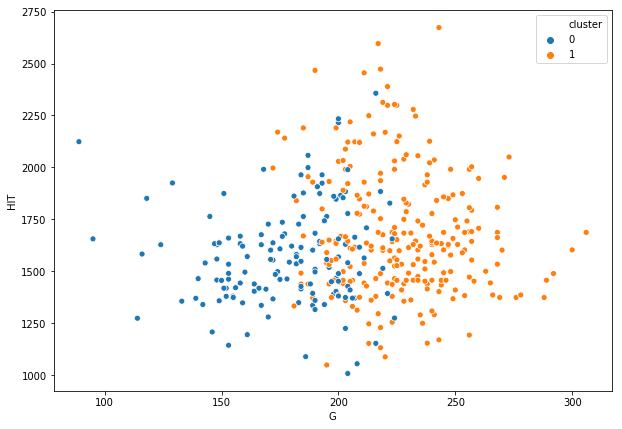

In [330]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=team_data, x='G', y='HIT', hue='cluster')
plt.show()

The teams are now seperated into two clusters. The above graph shows that while hits doesn't appear to have a big impact on the clustering, goals does seem to have a substantial impact. Now let's see how much the clusters correlate with getting into the playoffs and doing well in them.

In [298]:
#import packages for webscraping
from bs4 import BeautifulSoup
import requests

In [299]:
#Get Stanley Cup Winners

#get data from website
source = requests.get('https://www.hockey-reference.com/playoffs/').text
soup = BeautifulSoup(source, 'lxml')
year = []
for i in soup.find_all('tr'):
    x = i.find('th').text    
    year.append(x)

data = []
for i in soup.find_all('tr'):
    temp = []
    for j in i.find_all('td'):
        temp.append(j.text)
    data.append(temp)

data = data[2:]
year = year[2:]

#put data in dataframes
year_df = pd.DataFrame({'Year':year})
data_df = pd.DataFrame(data, columns=['league','winner','runner-up','mvp'])

#combine dataframes and select relevant data
winners_df = data_df.join(year_df)
winners_df.drop(columns=['league','mvp'], inplace=True)
winners_df.Year = winners_df.Year.astype(int)
winners_df = winners_df[winners_df.Year > 2003]
winners_df.drop(5, axis=0, inplace=True)
winners_df.drop(13, axis=0, inplace=True)

In [300]:
#for standardizing team designations
team_map = {'Anaheim Ducks':'ANA', 'Mighty Ducks of Anaheim':'ANA', 'Phoenix Coyotes':'ARI', 
            'Arizona Coyotes':'ARI', 'Boston Bruins':'BOS', 'Buffalo Sabres':'BUF', 
            'Carolina Hurricanes':'CAR', 'Columbus Blue Jackets':'CBJ', 'Calgary Flames':'CGY', 
            'Chicago Blackhawks':'CHI', 'Colorado Avalanche':'COL', 'Dallas Stars':'DAL', 
            'Detroit Red Wings':'DET', 'Edmonton Oilers':'EDM', 'Florida Panthers':'FLA', 
            'Los Angeles Kings':'LAK', 'Minnesota Wild':'MIN', 'Montreal Canadiens':'MTL', 
            'New Jersey Devils':'NJD', 'Nashville Predators':'NSH', 'New York Islanders':'NYI', 
            'New York Rangers':'NYR', 'Ottawa Senators':'OTT', 'Philadelphia Flyers':'PHI', 
            'Pittsburgh Penguins':'PIT', 'San Jose Sharks':'SJS', 'St. Louis Blues':'STL', 
            'Tampa Bay Lightning':'TBL', 'Toronto Maple Leafs':'TOR', 'Vancouver Canucks':'VAN', 
            'Vegas Golden Knights':'VEG', 'Atlanta Thrashers':'WPG', 'Winnipeg Jets':'WPG', 'Washington Capitals':'WSH'}  

In [301]:
#convert names
winners_df['winner']=winners_df['winner'].map(team_map)
winners_df['runner-up']=winners_df['runner-up'].map(team_map)

In [302]:
#Get Playoff Teams

#get data from website
playoff_dict = {}
seasons_to_get = list(range(2004, 2019))
seasons_to_get.remove(2005)
seasons_to_get.remove(2013)
for j in seasons_to_get:
    source = requests.get('https://www.hockey-reference.com/leagues/NHL_{}_standings.html'.format(j)).text
    soup = BeautifulSoup(source, 'lxml')

    tables = soup.find_all('tbody')
    names = []

    for i in tables[0].find_all('th'):
        x = i.text
        names.append(x)

    for i in tables[1].find_all('th'):
        x = i.text
        names.append(x)
        
    names = [i for i in names if '*' in i]
    
    teams = [i.replace('*', '') for i in names]
        
    playoff_dict[j] = teams

#put data in dataframe
playoff_df = pd.DataFrame(playoff_dict)

In [303]:
#convert names
for i in playoff_df.columns:
    playoff_df[i] = playoff_df[i].map(team_map)

In [304]:
#use playoff data to create new column
team_data['in_playoffs'] = 0
for i in team_data.Tm.unique():
    for j in team_data.Season.unique():
        if i in playoff_df[j].values:
            team_data.loc[(team_data.Tm==i) & (team_data.Season==j), 'in_playoffs'] = 1
            
#use stanley cup winner data to 
for i in winners_df[['runner-up', 'Year']].values:
    team_data.loc[(team_data.Tm==i[0]) & (team_data.Season==i[1]), 'in_playoffs'] = 2

for i in winners_df[['winner', 'Year']].values:
    team_data.loc[(team_data.Tm==i[0]) & (team_data.Season==i[1]), 'in_playoffs'] = 3

Now we have a column called 'in-playoffs' which has a value of 1 if the team was in the playoffs, 2 if the team made is to the championship game but lost, and 3 if the team won the championship. So it is an ordinal column where the higher value represents the greater achievement.

In [332]:
dummies = pd.get_dummies(team_data, columns=['cluster'])
dummies[['in_playoffs','cluster_1']].corr()

,in_playoffs,cluster_1
in_playoffs,1.000000,0.563301
cluster_1,0.563301,1.000000


We can see that being in cluster one is moderately correlated with being in the playoffs. So the investigation has been moderately successful. Let's now consider what accounts for the difference between the two groups. 

In [309]:
team_data.groupby('cluster').mean()

,Season,Player,G,A,S,PP,SH,BLK,HIT,FOW,FOL,Age,GP,plusminus,PIM,PS,ATOI,in_playoffs
cluster,,,,,,,,,,,,,,,,,,
0,2011.476000,26.18400,226.752000,386.284000,2374.608000,57.200000,7.408000,1048.202400,1681.976000,2302.787200,2284.6648,26.832370,52.966398,2.512800,33.989174,3.028301,14.293072,0.912000
1,2011.056738,28.12766,176.730496,300.255319,2012.879433,43.432624,5.900709,991.638298,1571.470922,2090.642553,2127.6000,25.993814,44.826982,-4.253136,30.212930,1.910331,14.134786,0.134752


As is to be expected, the cluster that is correlated with getting into the playoffs tend to score quite a few more goals than teams in the other cluster. 

# Future Work

Now that we have a process in place there are a few things to do to take this analysis further. One thing to do is to try different sets of features. One obvious reason to do this is that different sets of features may have higher correlation with being in the playoffs. Another reason to use different features is that there are some features not in the data above that make sense to include. The dataset used above was a conveninet option for using as a test case. But this dataset lacks features, such as goals against that capture relevant information about whether the team is good or not. Other interesting features to include would be possesion time, scoring chances, and corsi statistics, among others. 

A second thing to do is to try to dive deeper into what makes the groups different. At the level of team data we are bound to find that the more successful teams score more goals on average than the less successful teams. But what we really want to know is what causes more goals to be scored. We need to dig into the player level data, and not just data about how many goals each player scored. If we can do a cluster analysis on players to categorize them then we can figure out what sorts of players make-up each team. Then we could compare the make-ups of successful teams with the make-ups of unsuccessful teams. If we can find commone differences this could go a long way toward giving us an explanation of why some teams are successful and others are not.